In [7]:
import cinemaot as co
import numpy as np
import pertpy as pt
import scanpy as sc

In [8]:
adata = pt.dt.cinemaot_example()
adata

Output()

AnnData object with n_obs × n_vars = 1000 × 773
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden', 'cell_type0528'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type0528_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'cf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

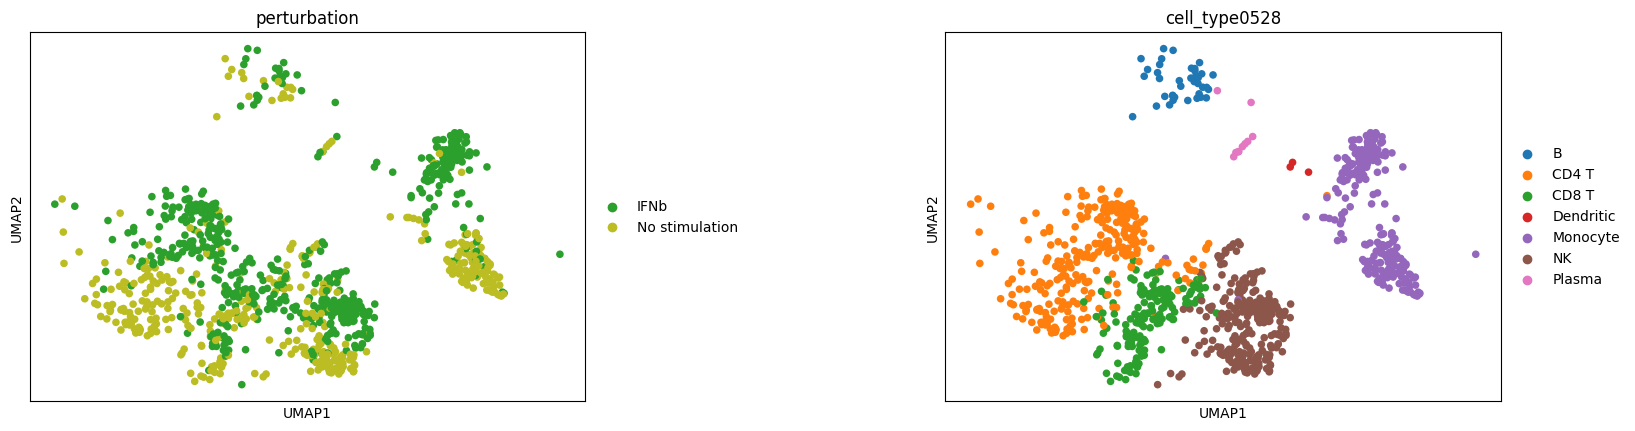

In [9]:
sc.pl.umap(adata, color=["perturbation", "cell_type0528"], wspace=0.5)

In [13]:
adata.X = adata.raw.X.copy()

In the original CINEMA-OT implementation, the method directly outputs the two main outputs: confounders before the optimal transport adjustment (cf_orig) and the single-cell level treatment effect (de_orig).
It also outputs the intermediate output of the optimal transport matching matrix (ot_orig).
We then compute the OT transformed confounder and store it in adata.obsm.

In [58]:
sc.pp.pca(adata)
cf_orig, ot_orig, de_orig = co.cinemaot.cinemaot_unweighted(
    adata,
    obs_label="perturbation",
    ref_label="IFNb",
    expr_label="No stimulation",
    mode="parametric",
    thres=0.5,
    smoothness=3e-5,
    eps=1e-3,
    preweight_label="cell_type0528",
)

adata.obsm["cf_orig"] = cf_orig.copy()
adata.obsm["cf_orig"][adata.obs["perturbation"] == "IFNb", :] = np.matmul(
    ot_orig / np.sum(ot_orig, axis=1)[:, None],
    cf_orig[adata.obs["perturbation"] == "No stimulation", :],
)

The Pertpy implementation of CINEMA-OT organizes its main outputs in the following way: OT transformed confounders are stored in the observation matrices of the original AnnData object (``adata.obsm['cf']``), while the OT matching matrix and single-cell treatment effects are stored in a new AnnData object (de) as ``de.obsm['ot']`` and ``de.X`` respectively.

In [61]:
cot = pt.tl.Cinemaot()
de = cot.causaleffect(
    adata,
    pert_key="perturbation",
    control="No stimulation",
    return_matching=True,
    thres=0.5,
    smoothness=3e-5,
    eps=1e-3,
    solver="Sinkhorn",
    preweight_label="cell_type0528",
)

We now compare the outputs of the original and Pertpy implementations of CINEMA-OT.
First, we show that the OT transformed confounders are nearly identical quantatively (by UMAP) and quantitatively (in terms of Frobenius norm).

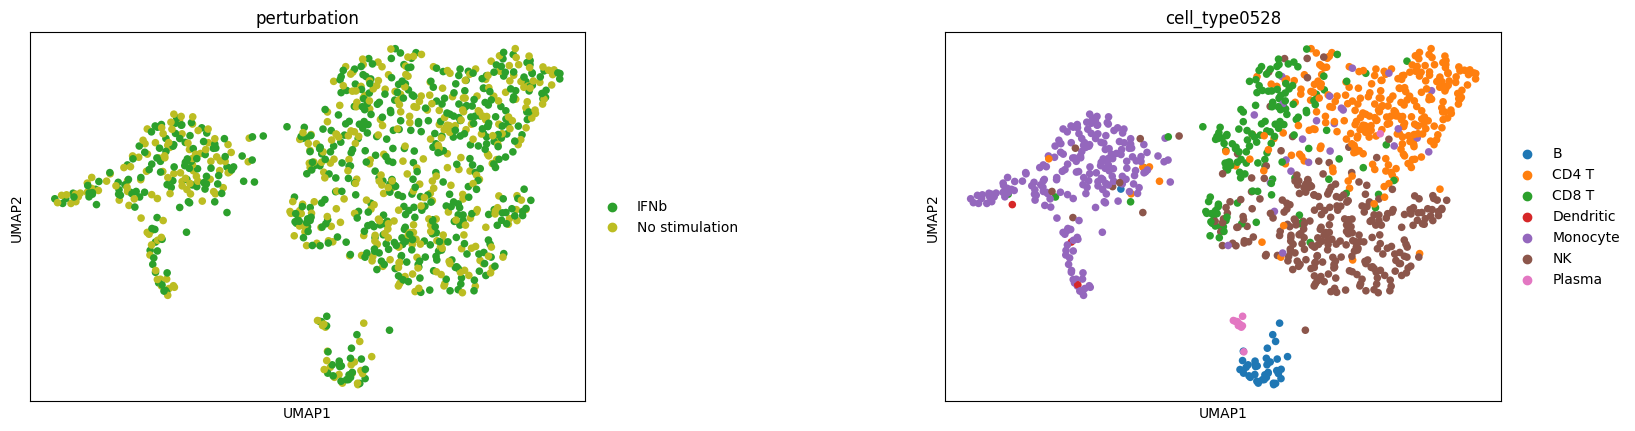

In [51]:
sc.pp.neighbors(adata, use_rep="cf_orig")
sc.tl.umap(adata, random_state=1)
sc.pl.umap(adata, color=["perturbation", "cell_type0528"], wspace=0.5)

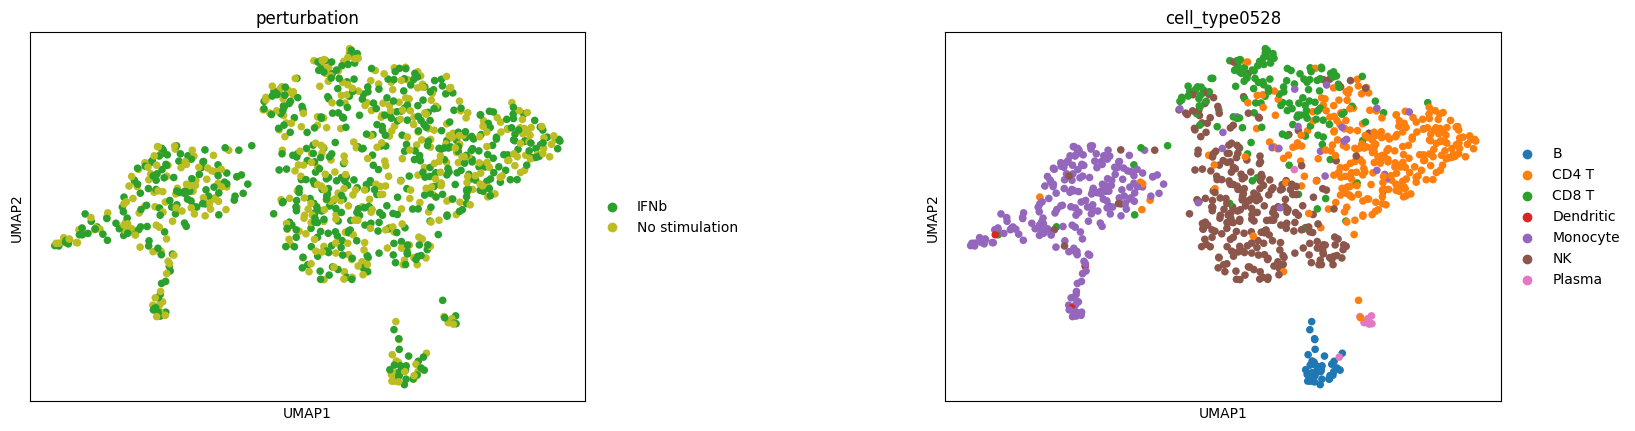

In [41]:
sc.pp.neighbors(adata, use_rep="cf")
sc.tl.umap(adata, random_state=1)
sc.pl.umap(adata, color=["perturbation", "cell_type0528"], wspace=0.5)

In [ ]:
print(
    f"Relative Frobenius norm difference: {np.linalg.norm(adata.obsm['cf_orig'] - adata.obsm['cf'], 'fro') / np.linalg.norm(adata.obsm['cf'], 'fro')}"
)

Relative Frobenius norm difference:  0.09727089


Now we compare the single-cell treatment effects of different implementations using Pearson and spearman correlations. We observe high Pearson and Spearman correlations (~0.99) of treatment effect across all genes.

In [ ]:
from scipy.stats import pearsonr, spearmanr


def column_wise_correlation(matrix1, matrix2, method="pearson"):
    n_cols = matrix1.shape[1]
    correlations = np.zeros(n_cols)

    for i in range(n_cols):
        col1 = matrix1[:, i]
        col2 = matrix2[:, i]

        if method.lower() == "pearson":
            correlation, _ = pearsonr(col1, col2)
        elif method.lower() == "spearman":
            correlation, _ = spearmanr(col1, col2)

        correlations[i] = correlation
    return correlations


pcorr = column_wise_correlation(de_orig.X, de.X, method="pearson")
spcorr = column_wise_correlation(de_orig.X, de.X, method="spearman")

<ipython-input-63-cfc54238232b>:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(col1, col2)
<ipython-input-63-cfc54238232b>:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(col1, col2)


Mean Pearson R: 0.9888790243909189
Mean Spearman R: 0.9830387947886666


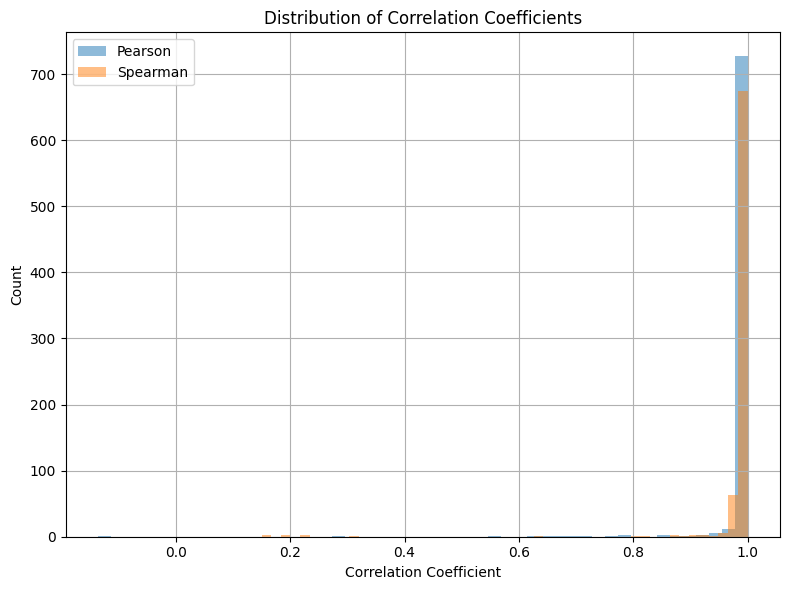

In [80]:
## Remove 12 genes having NaN values

print("Mean Pearson R:", np.mean(pcorr[~np.isnan(pcorr)]))
print("Mean Spearman R:", np.mean(spcorr[~np.isnan(spcorr)]))
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(pcorr[~np.isnan(pcorr)], bins=50, alpha=0.5, label="Pearson")
plt.hist(spcorr[~np.isnan(spcorr)], bins=50, alpha=0.5, label="Spearman")
plt.title("Distribution of Correlation Coefficients")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Finally we show that the two implementations consistently reveal the distinct treatment effect of monocytes.

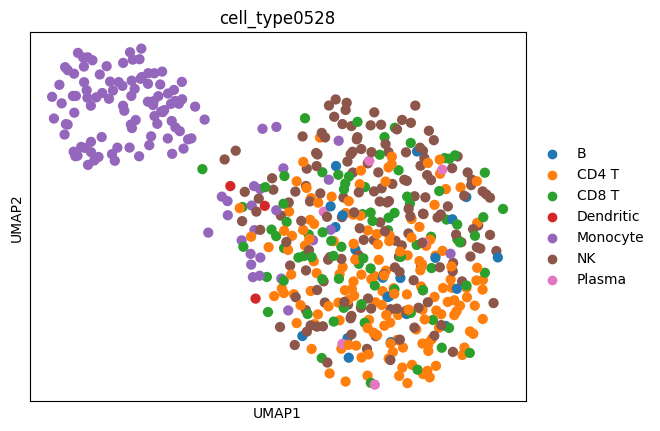

In [84]:
sc.pp.neighbors(de_orig, use_rep="X_embedding")
sc.tl.umap(de_orig)
sc.pl.umap(de_orig, color=["cell_type0528"])

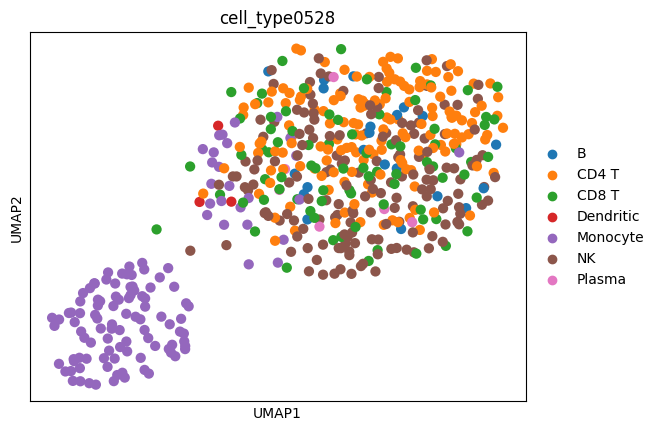

In [81]:
sc.pp.neighbors(de, use_rep="X_embedding")
sc.tl.umap(de)
sc.pl.umap(de, color=["cell_type0528"])